In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import pandas as pd

from scipy.io import mmread
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt


In [2]:
def integrate_dataset():
    adata = scanpy.read_loom("/data/groups/yhhuang/veloData/bone_marrow/SCG71.loom")
    l_pcs = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/pca.csv", index_col=0)
    l_genes = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/genes.csv", index_col=0)
    l_filtered_cells = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/filtered_cells.csv", index_col=0)
    l_clusters = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/cluster.csv", index_col=0)
    l_tsne = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/embeddings.csv", index_col=0)

    raw_cells = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/raw_mtx_cells.csv", index_col=0)
    raw_genes = pd.read_csv("/data/groups/yhhuang/veloData/bone_marrow/raw_mtx_genes.csv", index_col=0)
    raw_counts = mmread("/data/groups/yhhuang/veloData/bone_marrow/raw_counts.mtx").tocsr().T

    gene_idx = np.intersect1d(l_genes, raw_genes)
    cell_idx = np.intersect1d(adata.obs_names, l_filtered_cells.x.values) # intersection is l_filterred cells
    adata = adata[l_filtered_cells.x.values] # adata[l_filtered_cells.x.values]
    adata.obs['cluster'] = l_clusters.x.values
    adata.obsm['X_umap'] = l_tsne[['V1','V2']].values
    adata.obsm['X_pca'] = l_pcs.values
    adata = adata[:, gene_idx]

    raw_gene_dict = {gene:i for i,gene in enumerate(raw_genes.x.values)}
    raw_gene_indices = [raw_gene_dict[gene] for gene in gene_idx]
    raw_cell_dict = {cell:i for i, cell in enumerate(raw_cells.x.values)}
    raw_cell_indices = [raw_cell_dict[cell.split(":")[-1]] for cell in cell_idx]
    adata.X = raw_counts[raw_cell_indices][:, raw_gene_indices]

    adata.obsm['X_umap'] = (np.array([[0,-1],[1, 0]]) @ adata.obsm['X_umap'].T).T
    adata.obsm['X_umap'][:, 0] *= -1
    # adata.X = adata.layers['spliced'] + adata.layers['unspliced']
    print(adata)
    return adata


def get_selection(labels):
    sel = np.zeros(adata.n_obs,  dtype=np.bool)
    for lab in labels:
        sel = sel | (adata.obs.cluster == lab).values
    return sel

def annotate_cells():
    cluster_names = np.array(["              "]* adata.n_obs)
    label_list = [[7, 2], [1], [3], [5], [4, 6, 8]]
    cell_types = ['activating', 'dividing', 'progenitors', 'B cell lineage', 'macrophages']
    for labels, name in zip(label_list, cell_types):
        sel = get_selection(labels)
        cluster_names[sel] = name
    return cluster_names   

In [3]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'mousebonemarrow_model.cpt',
                               '--exp-name', 'CohAE_mousebonemarrow',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '5',
                               '--n_raw_gene', '2000',
                              ])

In [4]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [5]:
cluster_edges = []
k_cluster = "cell_type"
# k_cluster = "celltype" 
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [7]:
adata = integrate_dataset()
adata.obs['cell_type'] = annotate_cells()


AnnData object with n_obs × n_vars = 2600 × 21552
    obs: 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


['Cd79a' 'Cenpa' 'Il1b' 'Mmp9' 'Mpeg1']


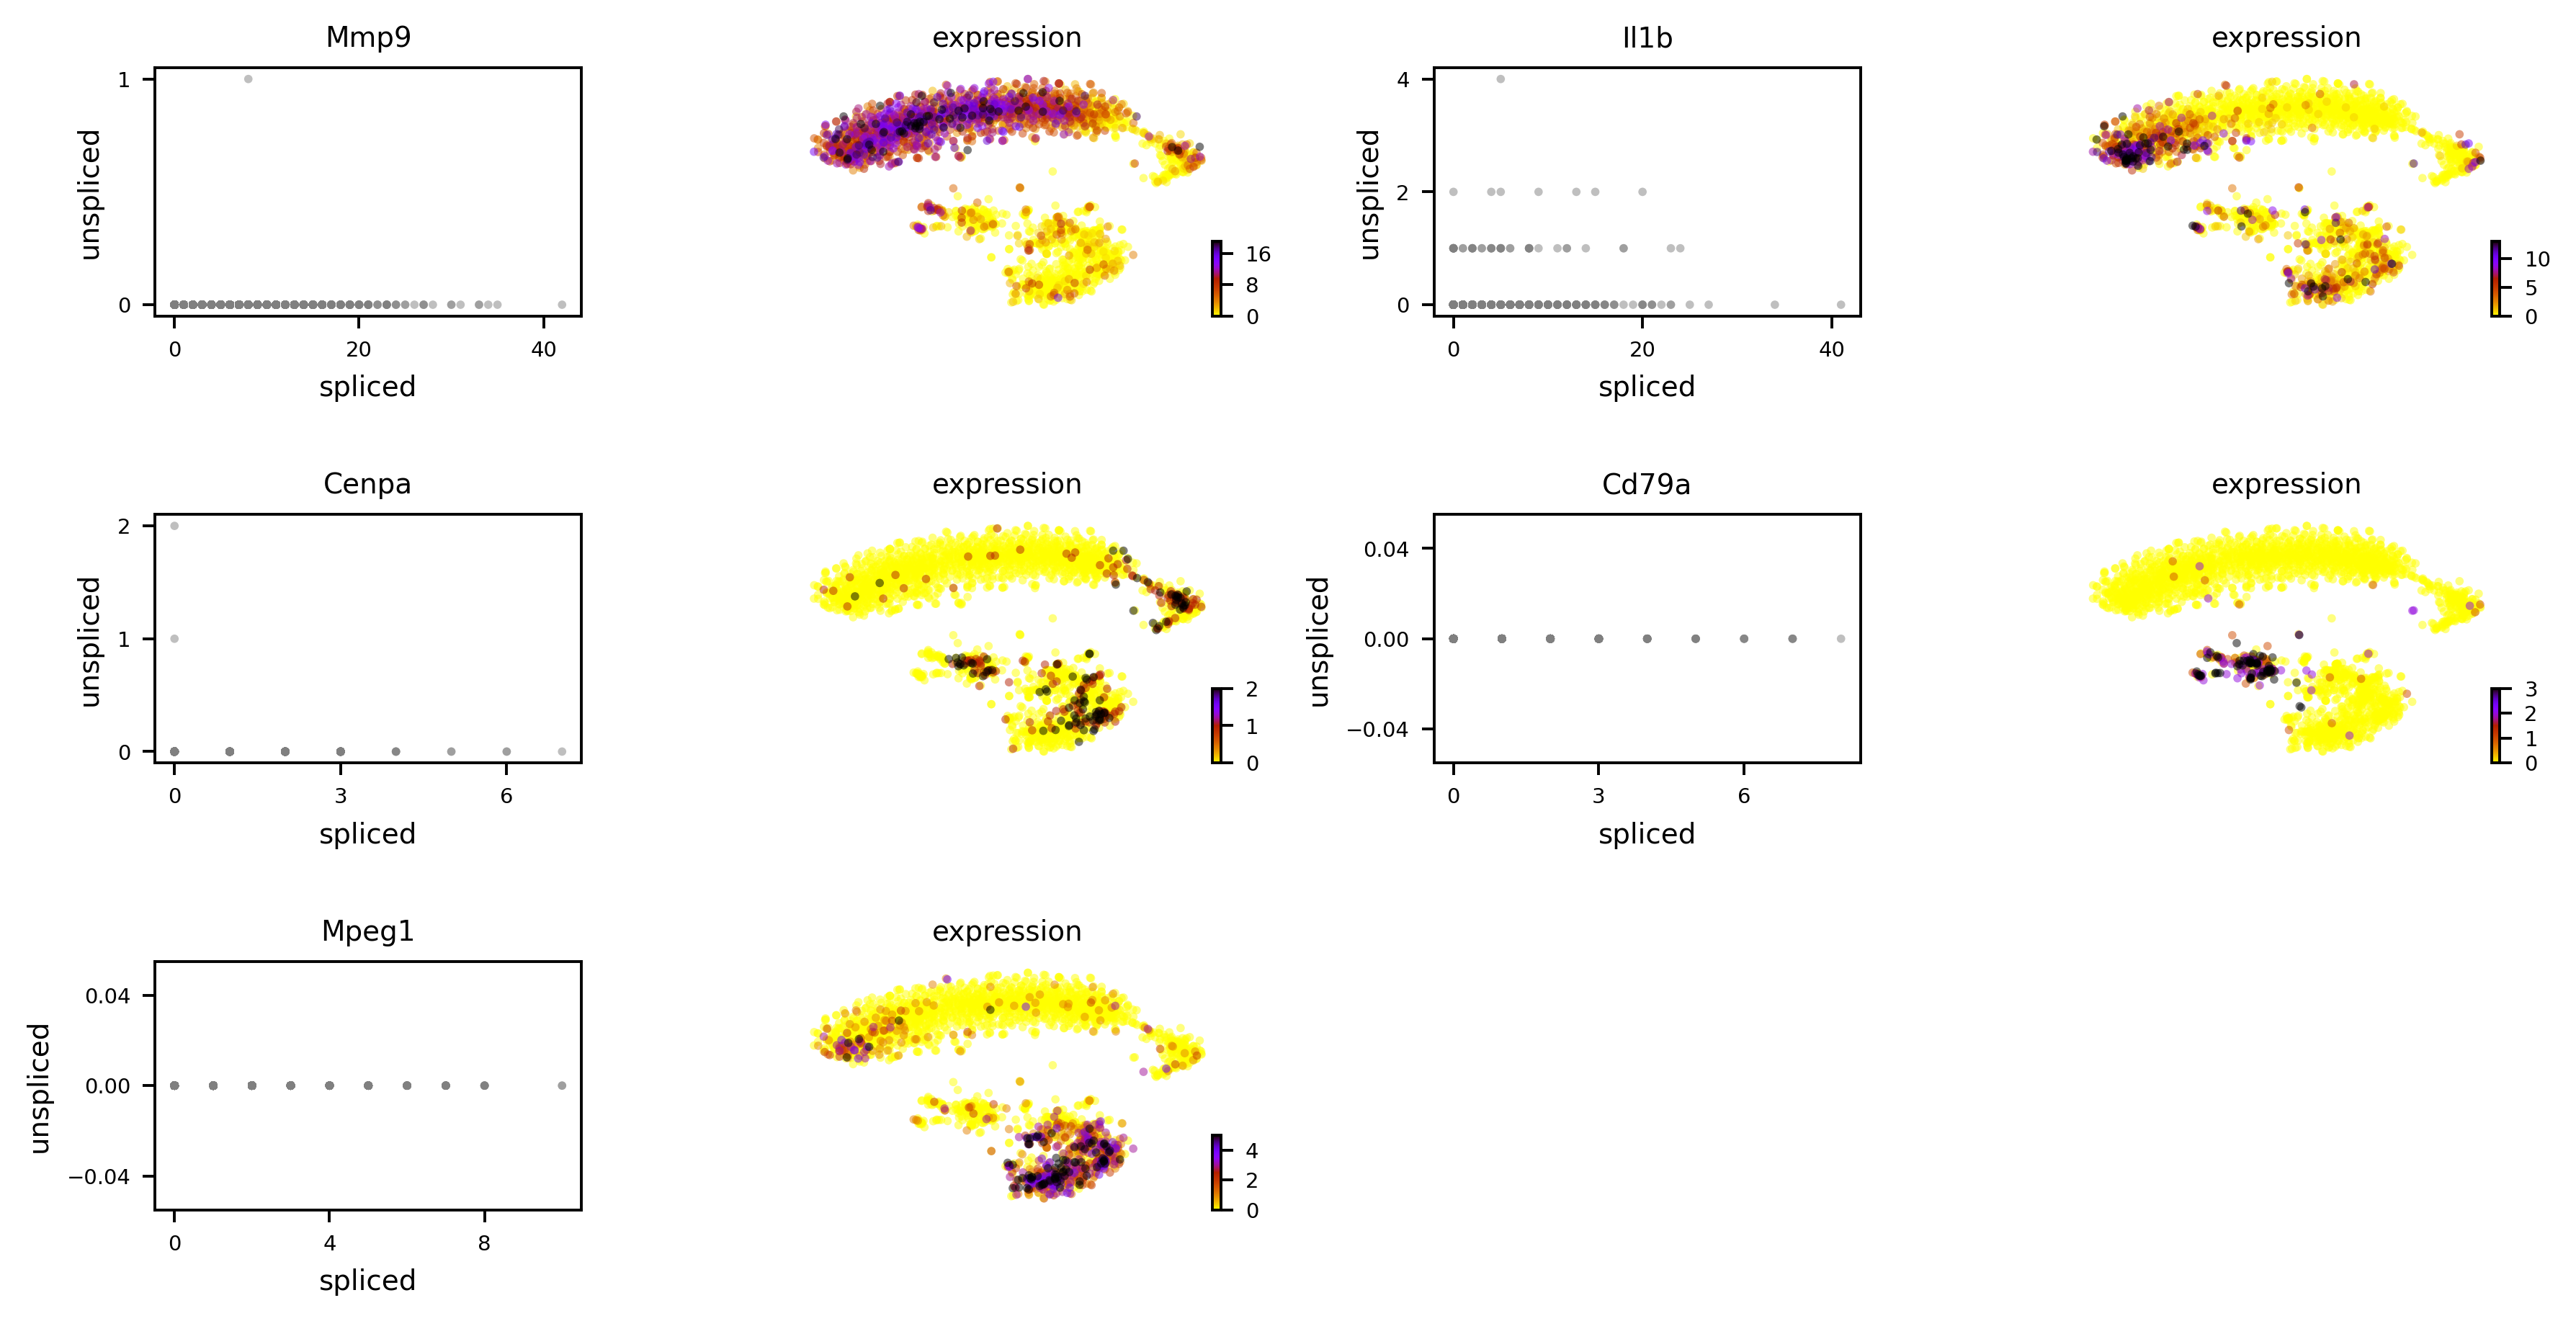

Abundance of ['spliced', 'unspliced']: [0.91 0.09]
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2600 × 2000
    obs: 'cluster', 'cell_type', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [8]:
# adata = scv.datasets.dentategyrus_lamanno()
# adata = scv.datasets.bonemarrow()
# adata = scv.datasets.pbmc68k()
# adata = scanpy.read_loom("/data/users/cqiao/projects/veloAE_rev2/VeloRep/mRNA_2_PBMCs_possorted_genome_bam_BJ2UE.loom")
# adata.obsm['X_umap'] = np.concatenate([adata.obs._X.values.reshape(-1, 1), adata.obs._Y.values.reshape(-1,1)], axis=1)
# adata.var_names_make_unique()
# scv.pp.remove_duplicate_cells(adata)
# adata.obsm["X_tsne"][:, 0] *= -1
# adata.obsm['X_umap'] = adata.obsm["X_tsne"]
# adata.obsm['X_umap'] = adata.obsm["X_pca"]
marker_genes = ["Mmp9", "Il1b", "Cenpa", "Cd79a", "Mpeg1"]
print(np.intersect1d(marker_genes, adata.var_names))
scv.pl.velocity(adata, marker_genes, ncols=2, dpi=350)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, # min_shared_counts=20, 
                            n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:08) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_mousebonemarrow_stc.png


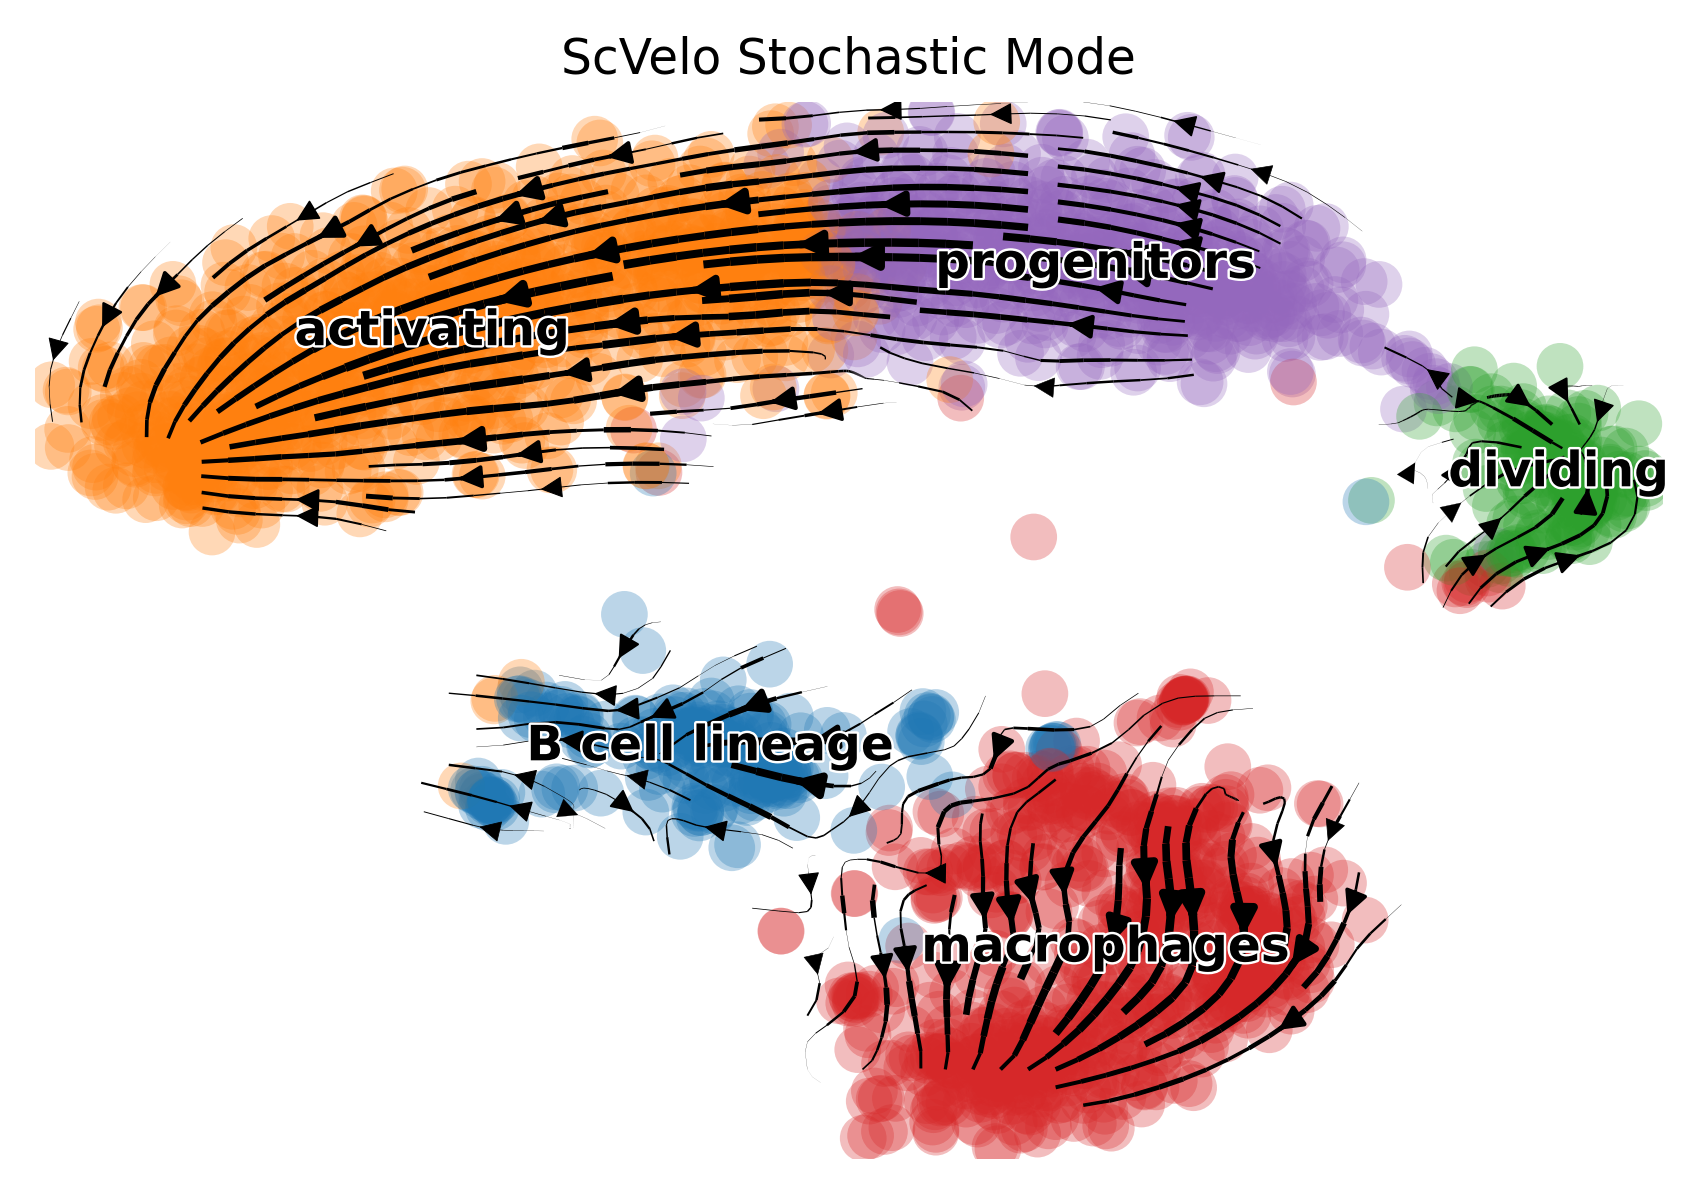

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'B cell lineage': 0.7634336, 'activating': 0.6522171, 'dividing': 0.6548008, 'macrophages': 0.67429566, 'progenitors': 0.6170607}
Total Mean: 0.6723614931106567
# In-cluster Confidence
{'B cell lineage': 0.6944683394555388, 'activating': 0.7036677280780144, 'dividing': 0.6736017243676288, 'macrophages': 0.7089355033545408, 'progenitors': 0.6368782520844047}
Total Mean: 0.6835103094680254


In [9]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=10)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                # legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis='X_umap', 
                                color=[k_cluster],
                                dpi=350, 
                                # legend_fontsize=6,
                                save="mousebonemarrow_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 0.177155
Train Epoch: 200/20000 	Loss: 0.176740
Train Epoch: 300/20000 	Loss: 0.176399
Train Epoch: 400/20000 	Loss: 0.175978
Train Epoch: 500/20000 	Loss: 0.175505
Train Epoch: 600/20000 	Loss: 0.175066
Train Epoch: 700/20000 	Loss: 0.174425
Train Epoch: 800/20000 	Loss: 0.173738
Train Epoch: 900/20000 	Loss: 0.172878
Train Epoch: 1000/20000 	Loss: 0.171843
Train Epoch: 1100/20000 	Loss: 0.170439
Train Epoch: 1200/20000 	Loss: 0.168766
Train Epoch: 1300/20000 	Loss: 0.166735
Train Epoch: 1400/20000 	Loss: 0.163401
Train Epoch: 1500/20000 	Loss: 0.158801
Train Epoch: 1600/20000 	Loss: 0.153909
Train Epoch: 1700/20000 	Loss: 0.148977
Train Epoch: 1800/20000 	Loss: 0.144516
Train Epoch: 

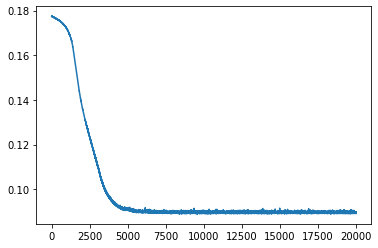

In [10]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/40 cores)
    finished (0:00:06) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/sc

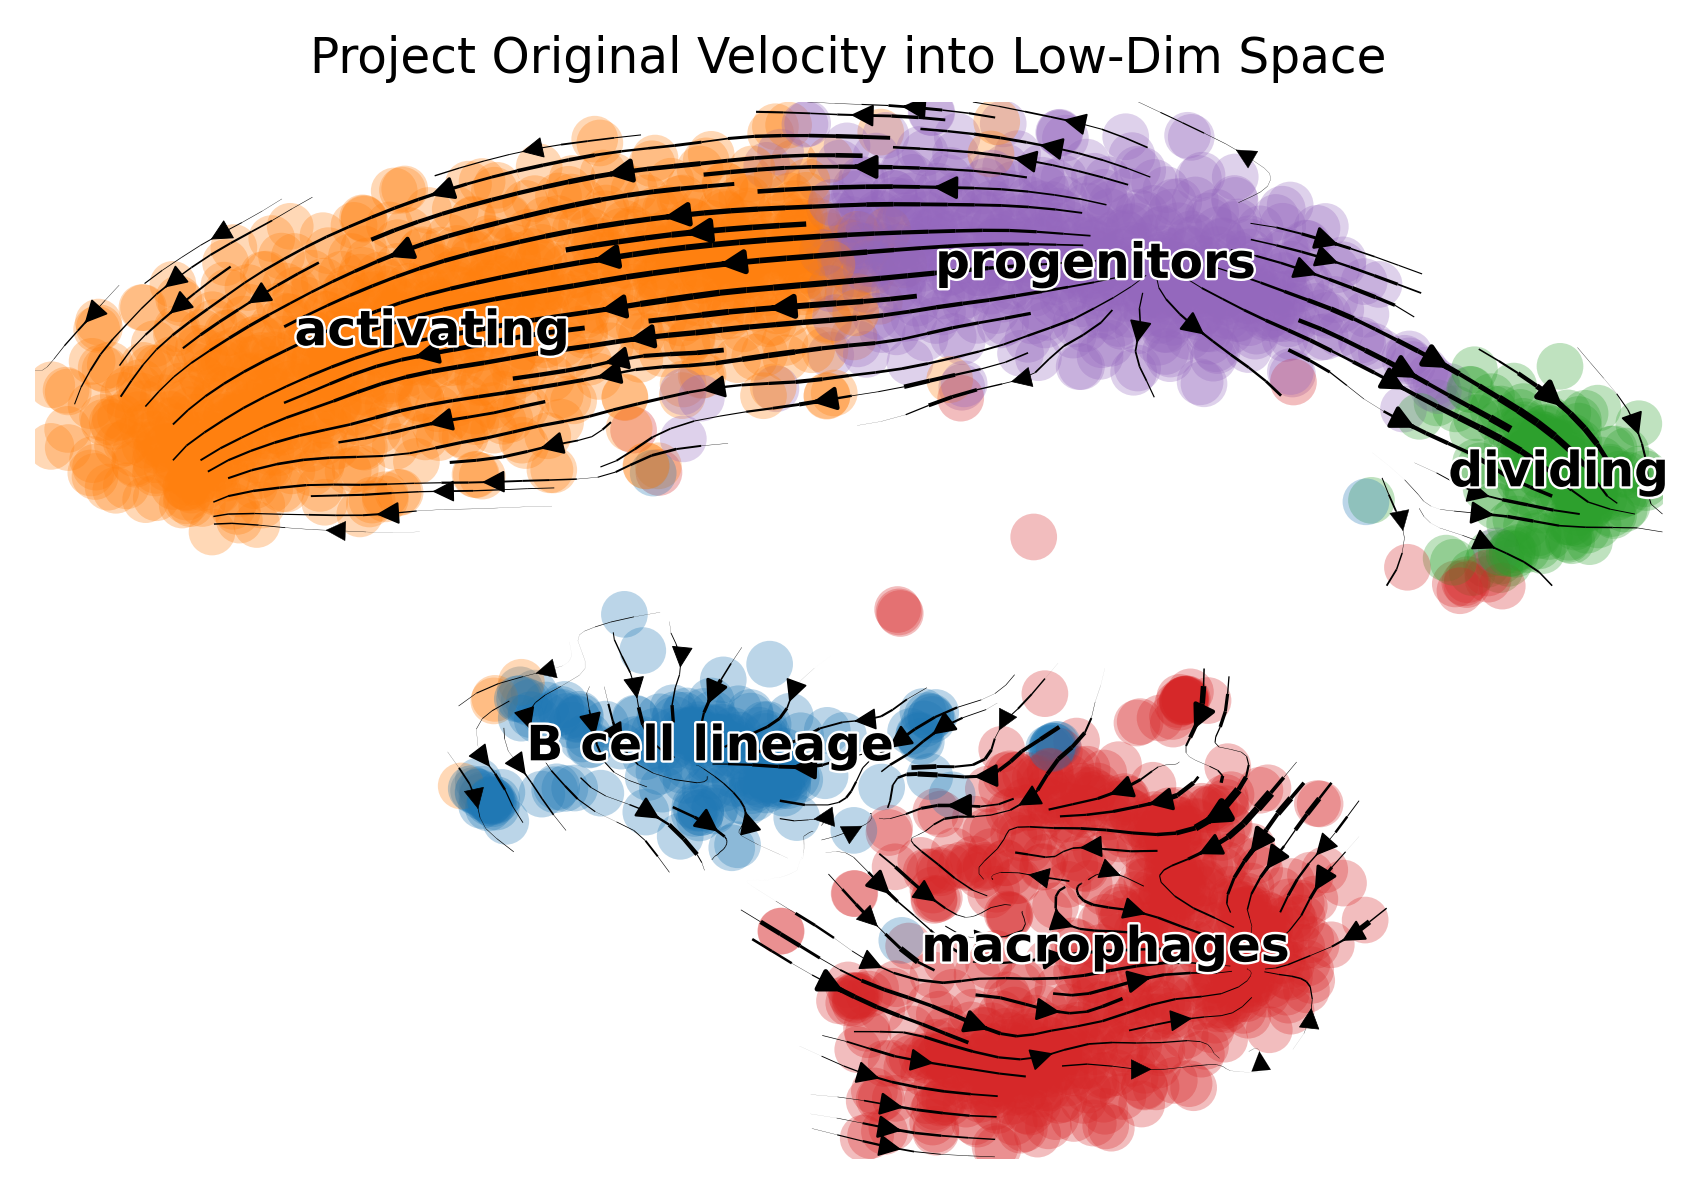

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'B cell lineage': 0.99985504, 'activating': 0.9998221, 'dividing': 0.99980694, 'macrophages': 0.9998065, 'progenitors': 0.9998955}
Total Mean: 0.9998372197151184
# In-cluster Confidence
{'B cell lineage': 0.9998187510104015, 'activating': 0.9998187337602887, 'dividing': 0.9997709300569309, 'macrophages': 0.9997692617637982, 'progenitors': 0.9998842321638691}
Total Mean: 0.9998123817510576


In [11]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, # legend_loc='right_margin', 
                                    vkey="new_velocity", basis='X_umap', color=[k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350, # legend_fontsize=6,
                                    save='mousebonemarrow_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)

AnnData object with n_obs × n_vars = 2600 × 21552
    obs: 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


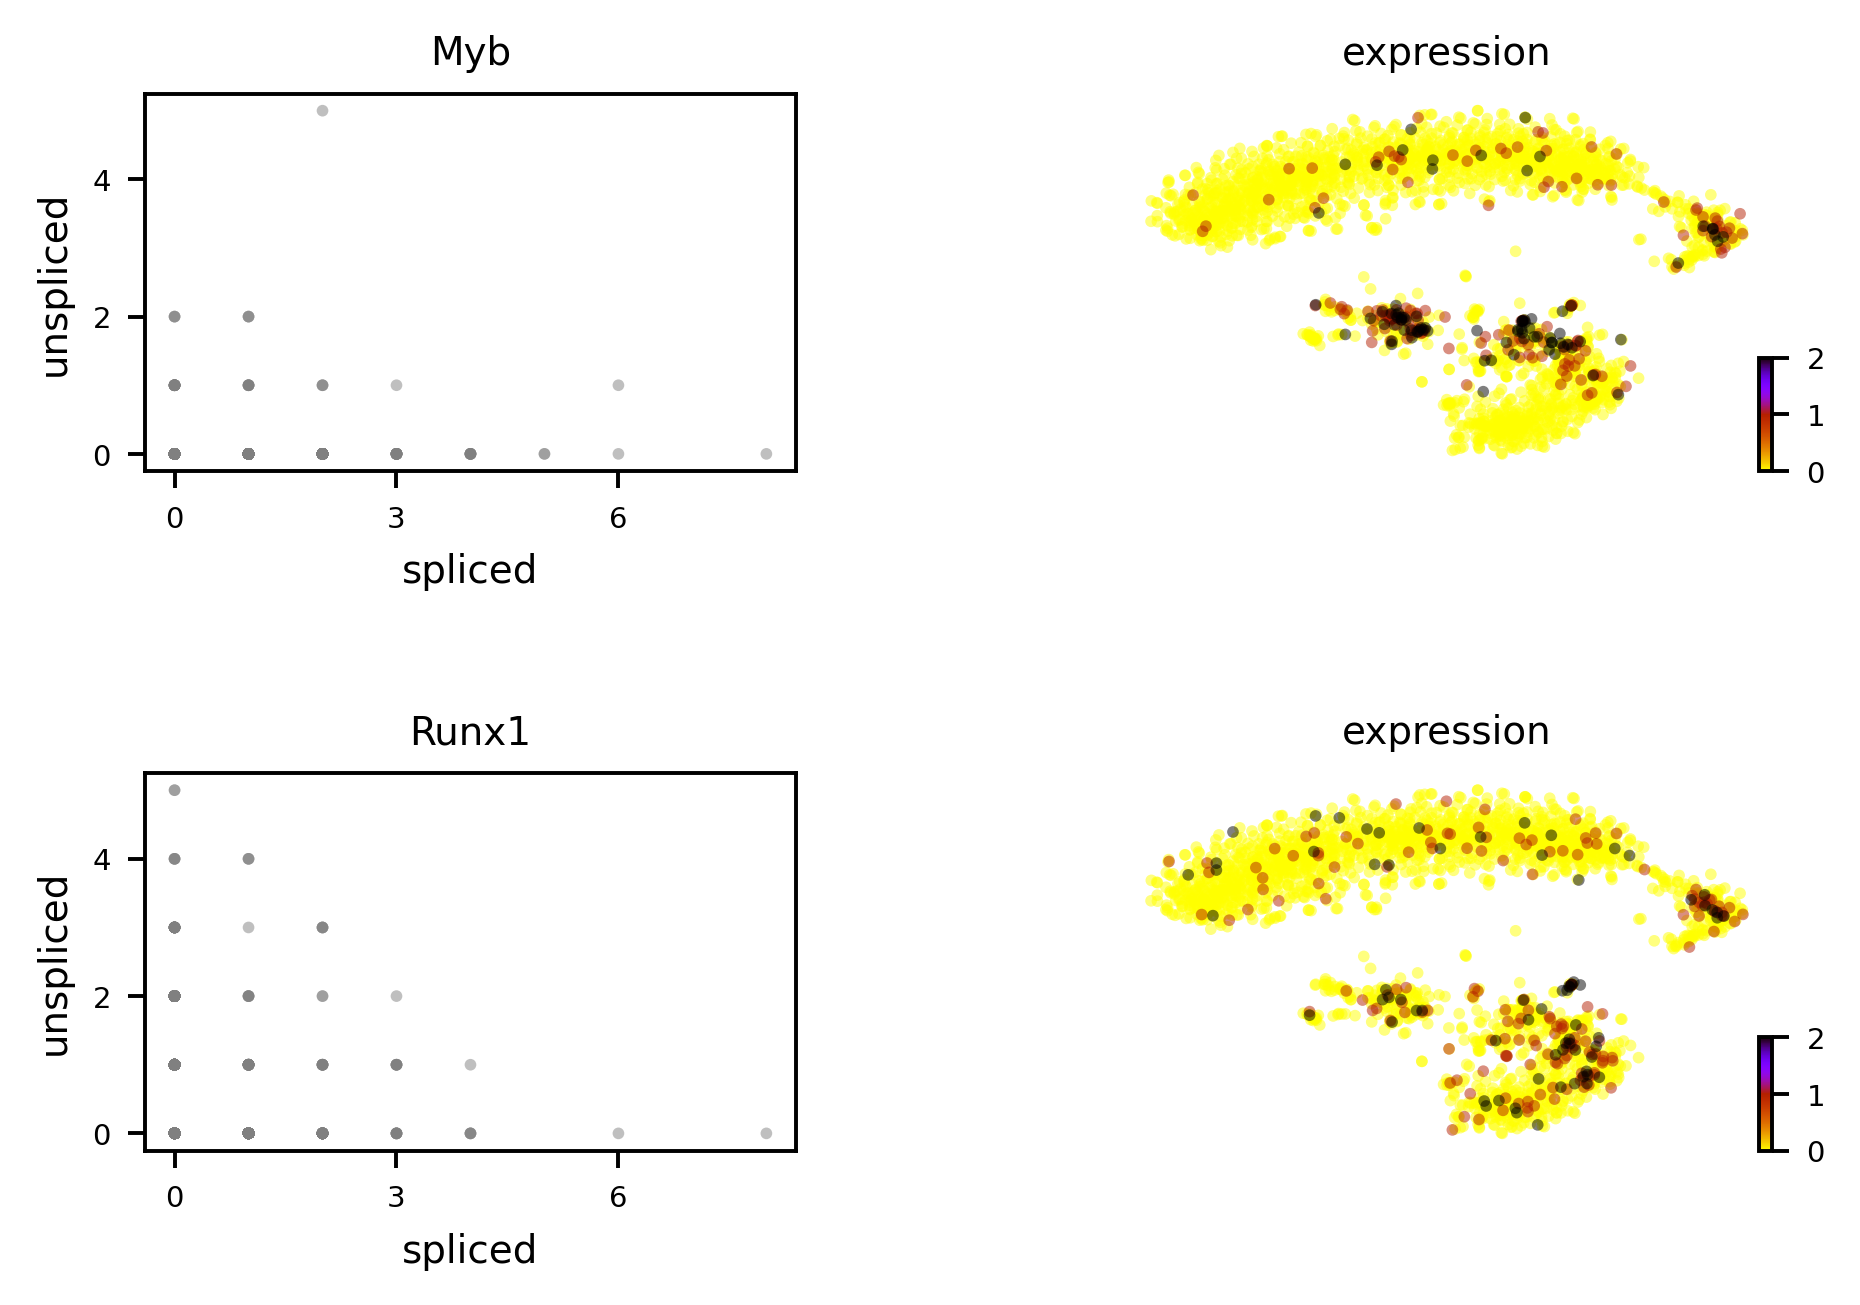

In [13]:

adata = integrate_dataset()
hsc_markers = ['Meiss1', 'Myb', 'Runx1', 'Tal1', 'Gata2', 'Fgd5', 'Mds1']
hsc_markers = ['Myb', 'Runx1']
scv.pl.velocity(adata, hsc_markers, nrows=2, dpi=350)

# plt.hist()


Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


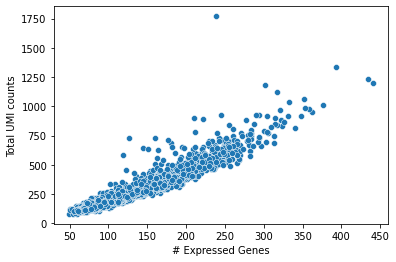

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
adata_cp = adata.copy()
scv.pp.filter_and_normalize(adata, # min_shared_counts=20, 
                            n_top_genes=args.n_raw_gene)
adata_cp = adata_cp[:, adata.var_names]
n_umis = np.sum(adata_cp.X.toarray(), axis=1)
n_umis = np.sum(adata_cp.X.toarray(), axis=1)
n_genes = np.sum(adata_cp.X.toarray() > 0, axis=1)
df = pd.DataFrame()
df['# Expressed Genes'] = n_genes
df['Total UMI counts'] = n_umis
sns.scatterplot(data=df, x="# Expressed Genes", y='Total UMI counts')
# plt.("# expressed genes")
# plt.ylabel("Total UMI counts")
plt.show()

Extracted 2000 highly variable genes.
2000


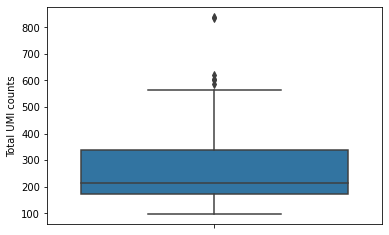

In [15]:
adata_cp = adata.copy()
scv.pp.filter_and_normalize(adata, # min_shared_counts=20, 
                            n_top_genes=args.n_raw_gene)
adata_cp = adata_cp[:, adata.var_names]
n_umis = np.sum(adata.X.toarray(), axis=1)
df = pd.DataFrame()
df['Total UMI counts'] = n_umis
sns.boxplot(data=df, y='Total UMI counts')
print(adata_cp.n_vars)